# Filtering for 10 days>

ChatGPT4 refactored the following codes.

In [1]:
import os
import numpy as np
import time
import gc
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft, ifft
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from read_gtool import *

## Initialize data dictionaries

In [2]:
original_daily_dict = {}
residual_dict = {}

In [3]:
original_vars_list = ["Ps", "u", "v", "qt"]

## Load dataset

In [4]:
for var in original_vars_list:
# for var in ["evap","prcp"]+original_vars_list:
    print(var)
    if var not in original_daily_dict:
        if var in ["u","v","qt"]:
            var_dataset = np.load(f'cat/1dy/{var}_l40.npz')
        else:
            var_dataset = np.load(f'cat/1dy/{var}.npz')
        original_daily_dict[var] = var_dataset[var]

Ps
u
v
qt


In [5]:
original_daily_dict["Ps"] = original_daily_dict["Ps"][:, :, np.newaxis, :]

## Retrieve common variables from dataset

In [6]:
lon3 = var_dataset['lon3']
lat3 = var_dataset['lat3']
lev3 = var_dataset['lev3']
y, m, d = var_dataset['y'], var_dataset['m'], var_dataset['d']

## Load lat-lon for 2-dim

In [7]:
var_dataset = np.load(f'cat/1dy/Ps.npz')
lon2, lat2 = var_dataset['lon2'], var_dataset['lat2']

In [8]:
del var_dataset

## Function definitions

In [9]:
# def calc_composite(var, axis=3):
#     last_colno=int(len(var.shape)-1)
#     try:
#         return np.nanmean(var, axis=axis)
#     except:
#         return np.nanmean(var, axis=last_colno)

# def dict_composite(var_dict, axis=3):
#     composite_dict = {var: calc_composite(data, axis=axis) for var, data in var_dict.items()}
#     return composite_dict

def calc_composite(var, axis=-1):
    return np.nanmean(var, axis=axis).squeeze()

def dict_composite(var_dict, axis=-1):
    composite_dict = {var: calc_composite(data, axis=-1) for var, data in var_dict.items()}
    return composite_dict

In [10]:
gt = read_gtool()
gt.var = "/home/kanon/local/gt2gr/gt3/GTAXLOC.HETA40.M"
zlev = gt.gtopen()[0,0,0,:-1]

dz = zlev[:-1] - zlev[1:]


def vertical_integration(var, ps, dz=dz, grav=9.8):
    """
    Perform vertical integration of a variable, which may or may not include a time dimension.

    Parameters:
    var (np.array): The input array to integrate vertically. Shape is assumed to be (xlen, ylen, zlen) or (xlen, ylen, zlen, tlen).
    ps (np.array): Surface pressure array with shape (xlen, ylen) or (xlen, ylen, tlen), matching var.
    dz (np.array): The thickness of each layer, with shape (zlen,).
    grav (float): The acceleration due to gravity.

    Returns:
    np.array: Vertically integrated values with shape (xlen, ylen) or (xlen, ylen, tlen), matching var.
    """
    # Determine if var includes a time dimension and adjust dz accordingly
    has_time_dimension = var.ndim == 4
    if has_time_dimension:
        # Shape (xlen, ylen, zlen, tlen) => Move the time dimension to the first axis for einsum convention
        var = np.moveaxis(var, -1, 0)
        # Expand dz to (tlen, zlen)
        dz_expanded = dz[np.newaxis, :]
        # 'tijk,k->tij' einsum pattern for the case with the time dimension
        varint = np.einsum('tijk,tk->tij', var, dz_expanded) / grav
        # Move the time dimension back to the last axis
        varint = np.moveaxis(varint, 0, -1)

        

    else:
        # For the case without the time dimension
        varint = np.einsum('ijk,k->ij', var, dz) / grav

    # Remove z-axis from Ps
    if ps.ndim ==varint.ndim+1:
        ps = ps[...,0,:]
    # Multiplication with surface pressure and adjustment by gravity        
    varint *= ps * 100.0

    return varint


In [11]:
def fft_filter(time_series, b, pad_to):
    N = len(time_series)
    F = fft(time_series, n=pad_to)  # zero-pad to match original shape
    H = fft(b, n=pad_to)
    return np.real(ifft(F * H)[:N])
    
def lanczos_filter(time_series, delta_t, f_cut, numtaps, pad_to):
    b = signal.firwin(numtaps, f_cut, window='lanczos', fs=1/delta_t, pass_zero=True)
    return fft_filter(time_series, b, pad_to)

# def batch_filter(start, end, value, filter_func, delta_t, f_cut, order, numtaps, output_array, pad_to):
#     if len(value.shape)==3:
#         try:
#             output_array[...,0,  :] = filter_func(value[..., :], delta_t, f_cut, order, pad_to)
#         except:
#             output_array[...,0,  :] = filter_func(value[..., :], delta_t, f_cut, numtaps, pad_to)
#     else:
#         for kk in range(start, end):
#             try:
#                 output_array[..., kk, :] = filter_func(value[..., kk, :], delta_t, f_cut, order, pad_to)
#             except:
#                 output_array[..., kk, :] = filter_func(value[..., kk, :], delta_t, f_cut, numtaps, pad_to)
def batch_filter(start, end, values, filter_function, delta_t, f_cut, order, numtaps, output_array, pad_to):
    """
    Apply a filter function to a batch of data.

    Parameters:
    start (int): Start index for filtering.
    end (int): End index for filtering.
    values (array-like): Input data to filter.
    filter_function (callable): The filter function to apply.
    delta_t (float): Sampling interval.
    f_cut (float): Cut-off frequency.
    order (int): Order of the filter (used if values have 3 dimensions).
    numtaps (int): Number of filter coefficients (taps).
    output_array (array-like): Array to store the filtered results.
    pad_to (int): The number of points to pad the data to.
    """

    # Define a helper function to apply the filter and handle exceptions
    def apply_filter(input_data, index=None):
        if numtaps != None:
            try:
                result = filter_function(input_data, delta_t, f_cut, numtaps, pad_to)
            except Exception as e:
                print(f"Filter function failed with exception: {e}.")
        else:
            try:
                result = filter_function(input_data, delta_t, f_cut, order, pad_to)
            except Exception as e:
                print(f"Filter function failed with exception: {e}.")
            
        return result

    # Apply filter based on the dimension of the input values
    if values.ndim == 3:
        output_array[..., 0, :] = apply_filter(values[..., :])
    else:
        for kk in range(start, end):
            output_data = apply_filter(values[..., kk, :], index=kk)
            output_array[..., kk, :] = output_data

# Example usage:
# batch_filter(start_index, end_index, input_values, my_filter_func, delta_t, f_cut, filter_order, filter_numtaps, output, pad_length)


In [12]:
def filtering(original_daily_dict, delta_t=1, f_cut=1/7, order=None, numtaps=None, filter_func=None, timeseries_dict={}):
    batch_size = 10  # Number of slices processed by each thread at a time. Adjust as needed.
    
    if filter_func is None:
        raise ValueError("A filter function must be provided.")

    for var, value in original_daily_dict.items():
        if not var in timeseries_dict.keys():
            print(f"Filtering {var}")

            dim_num = value.ndim
            gc.collect()
    
            if dim_num == 3:
                imt, jmt, tmt = value.shape
                kmt = 1
    
            elif dim_num == 4:
                imt, jmt, kmt, tmt = value.shape
            timeseries_array = np.zeros((imt, jmt, kmt, tmt), dtype=np.float32)
    
            num_batches = (kmt + batch_size - 1) // batch_size
            # Parallel processing
            with ThreadPoolExecutor() as executor:
                futures = [executor.submit(batch_filter, i*batch_size, min((i+1)*batch_size, kmt), value, filter_func, 
                delta_t, f_cut, order, numtaps, timeseries_array, tmt) for i in range(num_batches)]
    
                for future in futures:
                    future.result()
    
            timeseries_dict[var] = timeseries_array

        else:
            print(f"{var} is already existed in dictionary.")
    return timeseries_dict

In [13]:
def extract_keys(original_dict, keys_to_extract = {'uprecw', 'vprecw'}):
    return {key: original_dict[key] for key in keys_to_extract if key in original_dict}

## Filtering process

### Low-pass filter for >1y (Climatology)

In [14]:
# timeseries_3m_lp={}

# timeseries_3m_lp = filtering(
#     extract_keys(original_daily_dict,original_vars_list),
#     delta_t=1,
#     f_cut=1/(365/4),
#     numtaps=31,
#     filter_func=lanczos_filter,
#     timeseries_dict=timeseries_3m_lp
# )

# del timeseries_3m_lp

In [15]:
timeseries_1y_lp={}

In [16]:
timeseries_1y_lp = filtering(
    extract_keys(original_daily_dict,original_vars_list),    
#    extract_keys(original_daily_dict,original_vars_list+["evap","prcp"]),
    delta_t=1,
    f_cut=1/365,
    numtaps=365,
    filter_func=lanczos_filter,
    timeseries_dict=timeseries_1y_lp
)

Filtering Ps
Filtering u
Filtering v
Filtering qt


In [17]:
import numpy as np

def calculate_daily_climatology(original_daily_data):
    # 想定される tlen は 365 の倍数である必要がある
    assert original_daily_data.shape[-1] % 365 == 0, "The time dimension length must be a multiple of 365."

    # tlen を年数と 365 に分割
    years = original_daily_data.shape[-1] // 365
    daily_data_reshaped = original_daily_data.reshape(original_daily_data.shape[:-1] + (years, 365))

    # 年次次元に沿って平均を計算する
    daily_climatology = daily_data_reshaped.mean(axis=-2)

    return daily_climatology

# original_daily_data の例: np.random.rand(xlen, ylen, zlen, 365 * number_of_years)
# daily_climatology = calculate_daily_climatology(original_daily_data)


In [18]:
daily_climatology={}

In [19]:
for var in original_vars_list:
#    daily_climatology[var] = calculate_daily_climatology(timeseries_1y_lp[var])
    daily_climatology[var] = calculate_daily_climatology(original_daily_dict[var])

### Get residual

In [20]:
residual_dict_1y_lp={}

In [21]:

years=30
# オリジナルデータとclimatologyデータの形状が異なることに対応する
# original_daily_dict[var]のデータの年数を求める
#years = original_daily_dict["u"].shape[-1] // 365
for var in original_vars_list:
    if var not in residual_dict_1y_lp:

        # original_daily_dictからdaily_climatologyを年数分だけ繰り返したものを引いて辞書に追加する
#        residual_dict_1y_lp[var]  = np.subtract.outer(original_daily_dict[var], daily_climatology[var]).reshape(original_daily_dict[var].shape)
        residual_dict_1y_lp.update({var: original_daily_dict[var] - np.tile(daily_climatology[var], (1, 1, 1, years))})
#        residual_dict_3m_lp.update({var: orig

### Low-pass filter for >10 days

In [22]:
timeseries_10d_lp={}

In [23]:
timeseries_10d_lp = filtering(
    extract_keys(residual_dict_1y_lp,original_vars_list),
    # extract_keys(residual_dict_3m_lp,original_vars_list),
    delta_t=1,
    f_cut=1/10,
    numtaps=31,
    filter_func=lanczos_filter,
    timeseries_dict=timeseries_10d_lp
)

Filtering Ps
Filtering u
Filtering v
Filtering qt


### Calculate residuals (<10 days)

In [24]:
residual_dict_10d_lp={}

In [25]:
residual_dict_10d_lp.update({var: residual_dict_1y_lp[var] - timeseries_10d_lp[var] 
                      for var in residual_dict_1y_lp if var not in residual_dict_10d_lp})
# residual_dict_10d_lp.update({var: residual_dict_3m_lp[var] - timeseries_10d_lp[var] 
#                       for var in residual_dict_3m_lp if var not in residual_dict_10d_lp})

## Composite

## Original composite

In [26]:
original_daily_dict["uqt"] = np.multiply(original_daily_dict["u"],original_daily_dict["qt"])
original_daily_dict["vqt"] = np.multiply(original_daily_dict["v"],original_daily_dict["qt"])

original_daily_dict["uprecw"] =vertical_integration(original_daily_dict["uqt"],original_daily_dict["Ps"])

original_daily_dict["vprecw"] =vertical_integration(original_daily_dict["vqt"],original_daily_dict["Ps"])

In [27]:
original_composite_dict=dict_composite(original_daily_dict)

### Climatological

In [28]:
timeseries_1y_lp["uqt"] = np.multiply(timeseries_1y_lp["u"],timeseries_1y_lp["qt"])
timeseries_1y_lp["vqt"] = np.multiply(timeseries_1y_lp["v"],timeseries_1y_lp["qt"])

timeseries_1y_lp["uprecw"] =vertical_integration(timeseries_1y_lp["uqt"],original_daily_dict["Ps"])

timeseries_1y_lp["vprecw"] =vertical_integration(timeseries_1y_lp["vqt"],original_daily_dict["Ps"])

In [29]:
#timeseries_1y_lp["precw"]=vertical_integration(timeseries_1y_lp["qt"],original_daily_dict["Ps"])

In [30]:
timeseries_1y_lp_composite_dict=dict_composite(extract_keys(timeseries_1y_lp,["uprecw","vprecw","Ps"]))
timeseries_1y_lp_composite_dict=dict_composite(extract_keys(timeseries_1y_lp,["uprecw","vprecw","Ps"]))

### Low-pass filter (>10days)

In [31]:
timeseries_10d_lp["uqt"] = np.multiply(timeseries_10d_lp["u"],timeseries_10d_lp["qt"])
timeseries_10d_lp["vqt"] = np.multiply(timeseries_10d_lp["v"],timeseries_10d_lp["qt"])

timeseries_10d_lp_composite_dict = dict_composite(timeseries_10d_lp)

In [32]:
timeseries_10d_lp_composite_dict["uprecw"]=vertical_integration (timeseries_10d_lp_composite_dict["uqt"], original_composite_dict["Ps"])
timeseries_10d_lp_composite_dict["vprecw"]=vertical_integration (timeseries_10d_lp_composite_dict["vqt"], original_composite_dict["Ps"])

### Residual (<10days)

In [33]:
residual_dict_10d_lp["uqt"] = np.multiply(residual_dict_10d_lp["u"],residual_dict_10d_lp["qt"])
residual_dict_10d_lp["vqt"] = np.multiply(residual_dict_10d_lp["v"],residual_dict_10d_lp["qt"])

residual_composite_dict = dict_composite(residual_dict_10d_lp)

In [34]:
residual_composite_dict["uprecw"]=vertical_integration (residual_composite_dict["uqt"],original_composite_dict["Ps"])
residual_composite_dict["vprecw"]=vertical_integration (residual_composite_dict["vqt"], original_composite_dict["Ps"])

## Draw

In [35]:
def draw_around_Antarctica(draw_var_dict, colorbar_settings, c_lon=0, area=[0, 360, -90, -20], title=""):
    n_vars = len(draw_var_dict.keys())
    fig, axes = plt.subplots(1, n_vars, figsize=(5 * n_vars, 5), subplot_kw={'projection': ccrs.Stereographic(central_longitude=c_lon, central_latitude=-90)})
    fig.suptitle(title)

    if n_vars == 1:
        axes = [axes]

    for ax, var in zip(axes, draw_var_dict.keys()):
        try:
            vmin, vmax, vint = colorbar_settings[var]['vmin'], colorbar_settings[var]['vmax'], colorbar_settings[var]['vint']
        except:
            vmin, vmax, vint = -20,20,4

        try:
            cm = plt.get_cmap(colorbar_settings[var].get('cmap', 'seismic'))
        except:
            cm = plt.get_cmap(colorbar_settings["u"].get('cmap', 'seismic'))
        try:
            cs = ax.contourf(lon2, lat2, draw_var_dict[var],
                         levels=np.arange(vmin,vmax,vint),
                         cmap=cm, norm=Normalize(vmin=-vmax, vmax=vmax), extend="both",
                         transform=ccrs.PlateCarree())
        except:
            cs = ax.contourf(lon2, lat2, draw_var_dict[var][...,0],
                         levels=np.arange(vmin,vmax,vint),
                         cmap=cm, norm=Normalize(vmin=-vmax, vmax=vmax), extend="both",
                         transform=ccrs.PlateCarree())
        ax.coastlines(lw=0.5, color="gray", resolution="50m")

        ax.set_extent(area, crs=ccrs.PlateCarree())

        plt.colorbar(cs, shrink=0.6, orientation="horizontal", ax=ax, pad=0.05,label=var)

    plt.subplots_adjust(top=1,bottom=0.1,left=0.02,right=0.98,hspace=0.05,wspace=0.05)
    plt.show()

In [36]:
colorbar_settings = {
    # 'uprecw': {'vmin': -3, 'vmax': 3, 'vint':0.3 , 'cmap': 'seismic'},
    # 'vprecw': {'vmin': -3, 'vmax': 3, 'vint':0.3 , 'cmap': 'seismic'},
    'uprecw': {'vmin': -30, 'vmax': 30, 'vint':3 , 'cmap': 'seismic'},
    'vprecw': {'vmin': -30, 'vmax': 30, 'vint':3 , 'cmap': 'seismic'},
    
    'u': {'vmin': -20, 'vmax': 20, 'vint':2 , 'cmap': 'seismic'},
    'v': {'vmin': -20, 'vmax': 20, 'vint': 2, 'cmap': 'seismic'},
    'qt': {'vmin': 0, 'vmax': 0.01, 'vint': 0.0005, 'cmap': 'Greens'},
    'Ps': {'vmin': 0, 'vmax': 12, 'vint': 2, 'cmap': 'Greens'}
}

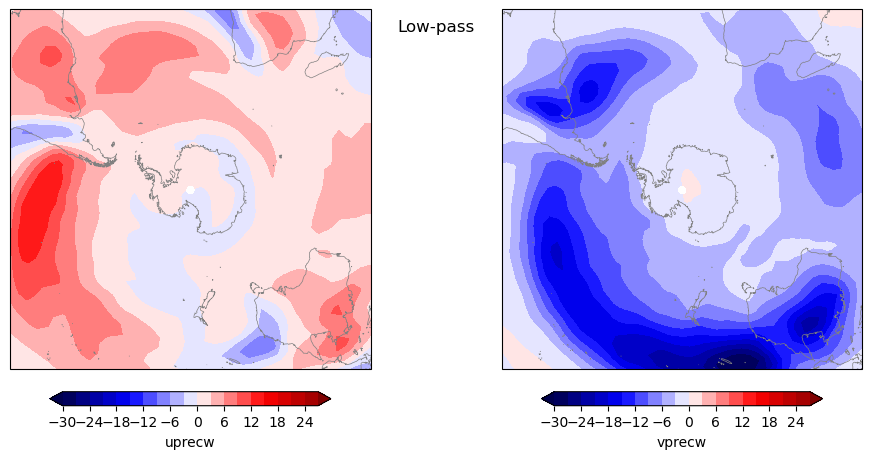

In [37]:
draw_around_Antarctica(extract_keys(timeseries_10d_lp_composite_dict), colorbar_settings,c_lon=0, title="Low-pass")

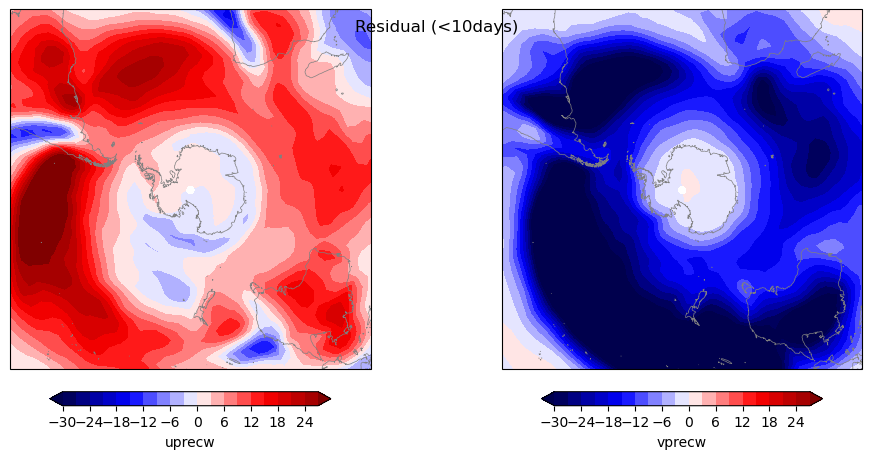

In [38]:
draw_around_Antarctica(extract_keys(residual_composite_dict), colorbar_settings,c_lon=0, title="Residual (<10days)")

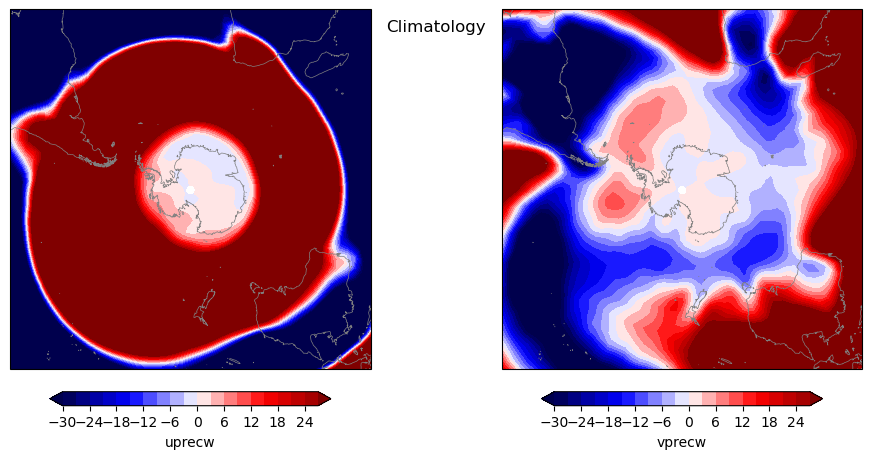

In [39]:
draw_around_Antarctica(extract_keys(timeseries_1y_lp_composite_dict), colorbar_settings,c_lon=0, title="Climatology")

## Save

In [40]:
import os
import numpy as np

def save_dict_npz(outfilename, save_dict, overwrite=False, 
                  lon3=None, lat3=None, lev3=None,
                  lat2=None, lon2=None):
    """
    Save the dictionary data to a file in NPZ format, with an option to overwrite existing files.

    Parameters:
    outfilename (str): The path to the output file.
    save_dict (dict): The dictionary containing the data.
    overwrite (bool): If True, the existing file will be overwritten.
    lon3, lat3, lev3, lat2, lon2: Additional data to save.

    The file is saved if it does not exist or if overwrite is True. Otherwise, a message is printed.
    """

    if not os.path.exists(outfilename) or overwrite:
        np.savez(outfilename, **save_dict, lon3=lon3, lat3=lat3, lev3=lev3, lat2=lat2, lon2=lon2)
        print(f"File saved: {outfilename}")
    else:
        print(f"File already exists: {outfilename}. Use overwrite=True to overwrite it.")

# Usage example:
# save_dict_npz("clm/ann/uvqt_10d_lp.npz", composite_10d_lp, overwrite=True)


In [41]:
#save_dict_npz("clm/ann/uvqt_1y_lp.npz",
save_dict_npz("clm/ann/uvqt_clm.npz",
timeseries_1y_lp_composite_dict, overwrite=True,
             lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)
#save_dict_npz("cat/1dy/uvqt_1y_lp.npz", 
save_dict_npz("cat/1dy/uvqt_clm.npz", 
              timeseries_1y_lp, overwrite=True,
             lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)

File saved: clm/ann/uvqt_clm.npz
File saved: cat/1dy/uvqt_clm.npz


In [42]:
#save_dict_npz("clm/ann/uvqt_10d_lp.npz", 
save_dict_npz("clm/ann/uvqt_10d_lp_clmanom.npz", 
timeseries_10d_lp_composite_dict, overwrite=True,
              lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)

#save_dict_npz("cat/1dy/uvqt_10d_lp.npz", 
save_dict_npz("cat/1dy/uvqt_10d_lp_clmanom.npz",               
              timeseries_10d_lp, overwrite=True,
             lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)

File saved: clm/ann/uvqt_10d_lp_clmanom.npz
File saved: cat/1dy/uvqt_10d_lp_clmanom.npz


In [43]:
#save_dict_npz("clm/ann/uvqt_10d_lp_residual.npz", 
save_dict_npz("clm/ann/uvqt_10d_lp_clmanom_residual.npz", 
residual_composite_dict, overwrite=True,
             lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)

#save_dict_npz("cat/1dy/uvqt_10d_lp_residual.npz", 
save_dict_npz("cat/1dy/uvqt_10d_lp_clmanom_residual.npz", 
residual_dict_10d_lp, overwrite=True,
             lon3=lon3, lat3=lat3, lev3=lev3,
              lat2=lat2, lon2=lon2)

File saved: clm/ann/uvqt_10d_lp_clmanom_residual.npz
File saved: cat/1dy/uvqt_10d_lp_clmanom_residual.npz


In [44]:
# save_dict_npz("clm/ann/uvqt_original.npz", original_composite_dict, overwrite=True,
#              lon3=lon3, lat3=lat3, lev3=lev3,
#               lat2=lat2, lon2=lon2)
# save_dict_npz("cat/1dy/uvqt_original.npz", original_daily_dict, overwrite=True,
#              lon3=lon3, lat3=lat3, lev3=lev3,
#               lat2=lat2, lon2=lon2)

## Area mean convergence

In [45]:
import numpy as np

def calculate_grid_area(lat=lat2, lon=lon2):
    # 地球の半径（メートル）
    earth_radius = 6370000  # default of MIROC
    
    # 経度グリッドの差分を計算（メートル）
    dlon = np.radians(np.gradient(lon, axis=0)) * earth_radius * np.cos(np.radians(lat))
    
    # 緯度グリッドの差分を計算（メートル）
    dlat = np.radians(np.gradient(lat, axis=1)) * earth_radius
    
    # グリッド面積を計算（メートル^2）
    grid_area = dlon * dlat
    
    return grid_area,dlat,dlon

def calculate_area_mean(var, grid_area=np.zeros((1,1)), lat=lat2, lon=lon2, lat_lim=-70):
    """領域平均を計算"""
    # 南緯lat_lim度以南のマスクを作成
    mask = lat < lat_lim
    if grid_area.shape != lat2.shape:
        # グリッド面積を計算
        grid_area,dlat,dlon = calculate_grid_area(lat, lon)
    return np.nansum(var * mask * grid_area) / np.nansum(mask * grid_area)

def calculate_convergence_areamean(vect_dic, lat=lat2, lon=lon2, lat_lim=-70):
    # グリッド面積を計算
    grid_area,dlat,dlon = calculate_grid_area(lat, lon)
    

    
    # 東西風の収束を計算
    u_convergence = -np.gradient(vect_dic["uprecw"], axis=1) / dlon
    
    # 南北風の収束を計算
    v_convergence = -np.gradient(vect_dic["vprecw"], axis=0) / dlat
    
    # 総収束を計算
    total_convergence = (u_convergence + v_convergence)
    
    # 領域平均を計算
    convergence_avg = calculate_area_mean(total_convergence, grid_area, lat=lat2, lon=lon2, lat_lim=-70)
    
    return convergence_avg

# 実際のデータで関数を使用する場合は以下のようになります。
# vect_dic = {"uprecw": uprecw, "vprecw": vprecw}
# convergence = calculate_convergence_areamean(vect_dic, lat, lon)
# print(convergence)

